In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot observed and modeled sea ice variables of interest.

'''
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import itertools
matplotlib.use('Agg')
import mpld3
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns


from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# from dask.distributed import Client
# client = Client()
# print(client)

#############################################################
# Load in Data
#############################################################



/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
E = ed.EsioData.load()

# Load in Obs
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'obs', 'NSIDC_0081' , 'standard')

#import timeit
#start_time = timeit.default_timer()
# ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc',concat_dim='time', 
#                                    autoclose=True, 
#                                    compat='no_conflicts',
#                                    data_vars=['sic','extent','area'])
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True)
#print(timeit.default_timer() - start_time)

# Get mean sic by DOY
mean_1980_2010_sic = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'mean_1980_2010_sic.nc')).sic

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/backends/api.py:637: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/backends/api.py:637: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/backends/api.py:637: FutureWarning: The autoclose argument is no longer used by xarray.open_

In [3]:
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))

In [4]:
# Load in regional data
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask_Update.nc'))
#############################################################

In [5]:
# Grab sic dataArrays
da_81 = ds_81.sic

In [6]:
# Get regional averages, redundant with calcs in Agg_NSIDC_obs but takes just a second
da_81reg = metrics.agg_by_domain(da_grid=da_81, ds_region=ds_region)

In [7]:
# Get date 30 days ago
ctime = np.datetime64(datetime.datetime.now())
lag_time_30days = ctime - np.timedelta64(30, 'D')
lag_time_90days = ctime - np.timedelta64(90, 'D')

# Select recent period
da_81_30 = da_81.where(da_81.time >= lag_time_30days, drop=True)
# Aggregate over domain
da_81_30_avg = metrics.calc_extent(da_81_30, ds_region, fill_pole_hole=True)

# Select recent period
da_81_3m = da_81.where(da_81.time >= lag_time_90days, drop=True)
# Aggregate over domain
da_81_3m_avg = metrics.calc_extent(da_81_3m, ds_region, fill_pole_hole=True)

In [8]:
# # Test regional sums
# da_test_nolake = ((da_81>=0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
# da_test = esio.calc_extent(da_81, ds_region, fill_pole_hole=True)
# %matplotlib inline
# da_81reg.sum(dim='nregions').plot(color='r', label='Sum of Regional Extents', linewidth=4)
# da_test_nolake.plot(color='b', label='Sum panArctic, Including Lakes')
# da_test.plot(color='k', label='Sum panArctic, Excluding Lakes')
# ds_ext.Extent.plot(color='m', label='NSIDC offical')
# plt.xlim([datetime.datetime(2018,3,1), datetime.datetime(2018,3,28)])
# plt.ylim([13.5,15])
# plt.legend()

In [9]:
# Set up plotting info
cmap_reg = matplotlib.colors.ListedColormap(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg_cycle = itertools.cycle(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg.set_bad(color = 'lightgrey')
linecycler = itertools.cycle(["-","--","-.",":","--"])

In [10]:
update = False
if update:
    # Plot regional  map(s)
    # Mask out other areas to missing
    mask_plot = ds_region.where(ds_region.mask.isin(ds_region.ocean_regions))

    (f, ax1) = ice_plot.polar_axis()
    f.set_size_inches(10, 5)
    p = mask_plot.mask.plot(ax=ax1,  x='lon', y='lat', 
                         transform=ccrs.PlateCarree(),
                        cmap=cmap_reg,
                        cbar_kwargs={'label':'','ticks': ds_region.ocean_regions});
    #                                  'labels':mask_plot.region_names.sel(nregions=plot_regs)})
    ax1.set_title('Regional Map')
    plt.tight_layout()
    cb = p.colorbar
    # X = list(plot_regs.values)
    # X.append(16)
    # X = np.array(X)-0.5
    # cb.ax.set_yticks(X);
    cb.ax.set_yticklabels(mask_plot.region_names.sel(nregions=ds_region.ocean_regions).values);
    f.savefig(os.path.join(fig_dir,'Regional_Map.png'),bbox_inches='tight',dpi=200)

In [11]:
# start regional maps on 9-1 of previous year, until Oct and then make it this year

X = ctime.astype(object)
if X.month<=9:
    yyyy = X.year-1
else:
    yyyy = X.year
start_date = np.datetime64(str(yyyy)+'-09-01')

start_date

numpy.datetime64('2019-09-01')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  

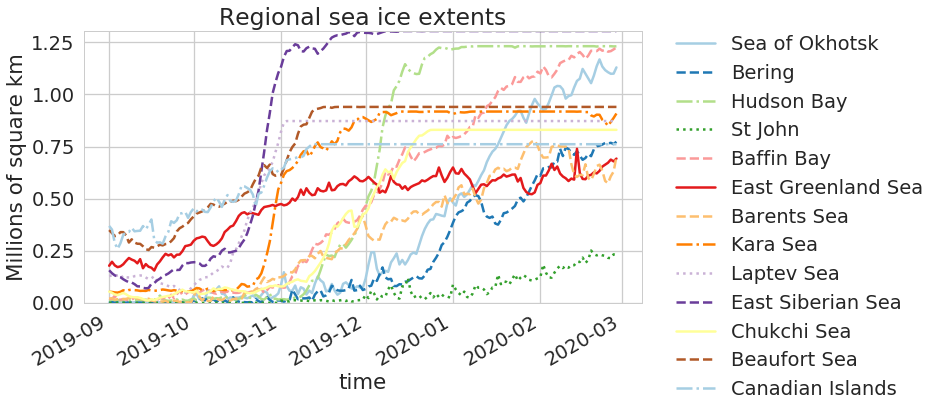

In [12]:
# Set up plotting info
cmap_reg = matplotlib.colors.ListedColormap(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg_cycle = itertools.cycle(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg.set_bad(color = 'lightgrey')
linecycler = itertools.cycle(["-","--","-.",":","--"])

# Plot regional sea ice extents (last 90 days), takes a while
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)
cmax = 0
for cd in da_81reg.nregions:
    # Don't plot central arctic (boring)
    if da_81reg.region_names.sel(nregions=cd) == 'Central Arctic':
        continue
    cdata = da_81reg.where(da_81reg.time >= start_date, 
                   drop=True).sel(nregions=cd)
    cdata.plot(label=da_81reg.region_names.sel(nregions=cd).values,
                                                   color=next(cmap_reg_cycle),
                                                   linestyle=next(linecycler))
    cmax = np.max([cmax,cdata.max().values])
ax1.set_title('Regional sea ice extents')
ax1.set_ylabel('Millions of square km')
ax1.set_ylim([0,cmax])
plt.legend(bbox_to_anchor=(1.03, 1.05))
f_name = os.path.join(fig_dir,'panArcticSIC_Forecast_Regional_CurrentSeason')
f.savefig(f_name+'.png',bbox_inches='tight',dpi=200)
#mpld3.save_json(f, f_name+'.json')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  

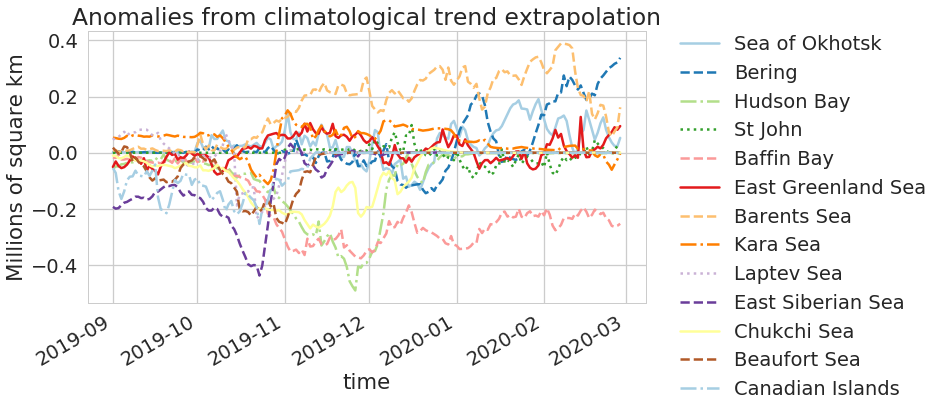

In [13]:
# Set up plotting info
cmap_reg = matplotlib.colors.ListedColormap(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg_cycle = itertools.cycle(sns.color_palette("Paired", da_81reg.nregions.size))
cmap_reg.set_bad(color = 'lightgrey')
linecycler = itertools.cycle(["-","--","-.",":","--"])

da_climo = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly_agg_climatology/*.nc', concat_dim='time')
da_climo = da_climo.ClimoTrendExtent

cdata = da_81reg.where(da_81reg.time >= start_date, drop=True) - da_climo.where(da_climo.time >= start_date, drop=True) 

f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)

for cd in da_81reg.nregions:
    # Don't plot central arctic (boring)
    if da_81reg.region_names.sel(nregions=cd) == 'Central Arctic':
        continue

    cdata.sel(nregions=cd).plot(label=da_81reg.region_names.sel(nregions=cd).values,
                                                   color=next(cmap_reg_cycle),
                                                   linestyle=next(linecycler))
    
ax1.set_title('Anomalies from climatological trend extrapolation')
ax1.set_ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f_name = os.path.join(fig_dir,'panArcticSIC_Forecast_RegionalAnomalies_CurrentSeason')
f.savefig(f_name+'.png',bbox_inches='tight',dpi=200)


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


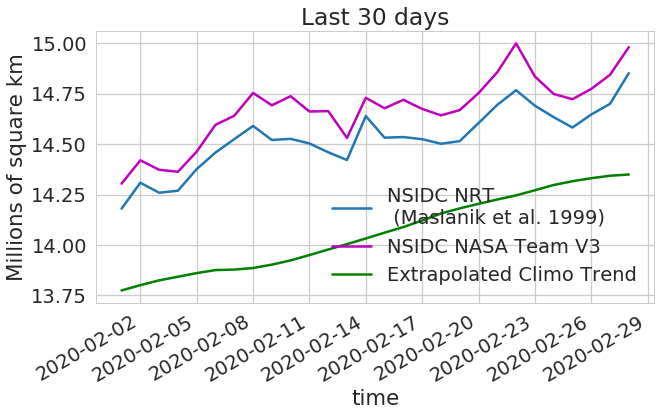

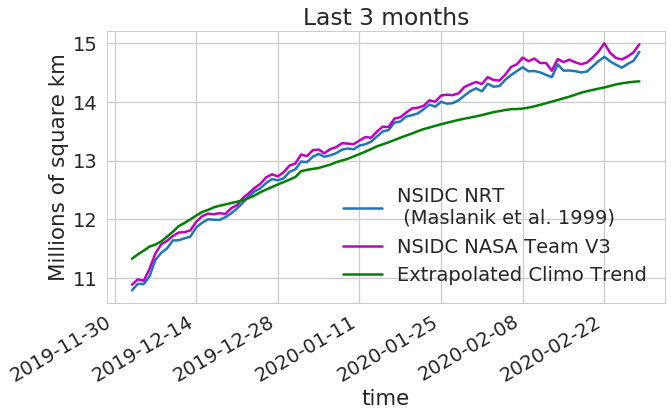

In [14]:
## Plot Extents

# last 30 days
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
da_81_30_avg.plot(ax=ax1, label='NSIDC NRT\n (Maslanik et al. 1999)')
ds_ext.sel(datetime=da_81_30_avg.time).Extent.plot(label='NSIDC NASA Team V3', color='m')
da_climo.sel(nregions=99).sel(time=da_81_30_avg.time).plot(label='Extrapolated Climo Trend', color='g')
ax1.set_ylabel('Millions of square km')
#plt.legend(loc='lower right') #bbox_to_anchor=(1.03, 1.05))
plt.legend()
# Save to png and json (for website)
f_name = os.path.join(fig_dir,'panArcticSIC_Forecast_30days')
plt.title('Last 30 days')
f.savefig(f_name+'.png',bbox_inches='tight',dpi=200)
mpld3.save_json(f, f_name+'.json')
mpld3.save_html(f, f_name+'.html')


# last 3 months
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
da_81_3m_avg.plot(ax=ax1, label='NSIDC NRT\n (Maslanik et al. 1999)')
ds_ext.sel(datetime=da_81_3m_avg.time).Extent.plot(label='NSIDC NASA Team V3', color='m')
da_climo.sel(nregions=99).sel(time=da_81_3m_avg.time).plot(label='Extrapolated Climo Trend', color='g')
plt.title('Last 3 months')
ax1.set_ylabel('Millions of square km')
#plt.legend(loc='lower right')
plt.legend()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_3months.png'),bbox_inches='tight',dpi=200)

In [15]:
cbar_kwargs={'label':'Sea Ice Concentration (-)','size':12}

# read in the climo trend for this doy and year
cdoy = pd.to_datetime(ctime).timetuple().tm_yday
cyear = pd.to_datetime(ctime).timetuple().tm_year

#files are this format 2019_262_1990_2018_SIC.nc
climo_file = os.path.join(E.model_dir,'climatology','forecast','sipn_nc')+'/'+str(cyear)+'_'+format(cdoy, '03')+'_1990_'+str(cyear-1)+'_SIC.nc'

da_climo = xr.open_mfdataset(climo_file)
da_climo = da_climo.sic.squeeze()

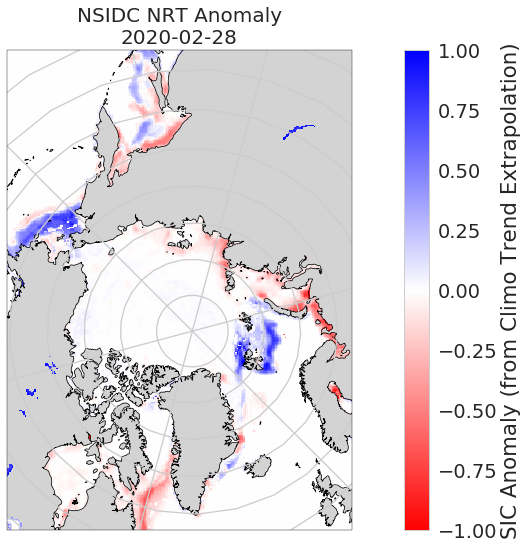

In [16]:
# Plot Recent maps

# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')
cmap_dif = matplotlib.colors.ListedColormap(sns.color_palette("RdBu", 10))
cmap_dif.set_bad(color = 'lightgrey')


cmap_diff_2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
cmap_diff_2.set_bad(color = 'lightgrey')

# anomaly from climo trend
(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(15, 8)
#f.set_size_inches(10, 5)
obs1 = da_81.sel(time=ctime, method='nearest')
(obs1-da_climo).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_diff_2,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'SIC Anomaly (from Climo Trend Extrapolation)'})
ax1.set_title('NSIDC NRT Anomaly\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'), fontsize=20)
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_SIC_anomaly_fromClimoTrend.png'),bbox_inches='tight',dpi=200)

Make figs for periods range of :  2020-02-23T00:00:00.000000000  to  2020-03-01T00:00:00.000000000
2020-02-17T00:00:00.000000000 2020-02-23T00:00:00.000000000
<xarray.DataArray 'sic' (time: 7, y: 448, x: 304)>
[953344 values with dtype=float64]
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 ...
    lon      (x, y) float64 ...
    xm       (x) int64 ...
    ym       (y) int64 ...
  * time     (time) int64 48 49 50 51 52 53 54


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2020-02-24T00:00:00.000000000 2020-03-01T00:00:00.000000000
<xarray.DataArray 'sic' (time: 7, y: 448, x: 304)>
[953344 values with dtype=float64]
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 ...
    lon      (x, y) float64 ...
    xm       (x) int64 ...
    ym       (y) int64 ...
  * time     (time) int64 55 56 57 58 59 60 61


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


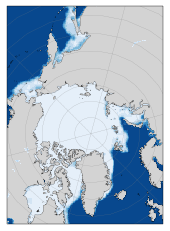

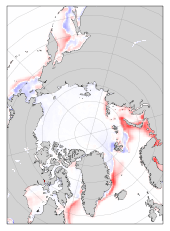

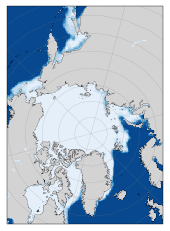

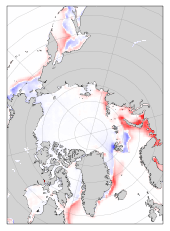

In [17]:
updateAll = False # if update all make figures since start of sipn, otherwise just make last few weeks

start_t = datetime.datetime(1950, 1, 1)  # Hardcoded start date (makes incremental weeks always the same)
currentday = datetime.datetime.now()
init_slice = np.arange(start_t, currentday, datetime.timedelta(days=7)).astype('datetime64[ns]')

if updateAll:
    init_start_date = np.datetime64('2018-01-01') # make all figs since start
else:
    init_start_date = init_slice[-1]-np.timedelta64(13, 'D') # make figs for last couple of weeks

init_slice = init_slice[init_slice>=init_start_date] # Select only the inits after init_start_date
print('Make figs for periods range of : ',init_slice[0], ' to ',init_slice[-1])

fig_dir = os.path.join(E.fig_dir, 'obs', 'NSIDC_0081' , 'verification')

for lastdate in init_slice:
    firstdate=lastdate-np.timedelta64(6, 'D')
    print(firstdate,lastdate)

    tmp=da_81.sel(time=slice(firstdate,lastdate))
    cdoystart = pd.to_datetime(firstdate).timetuple().tm_yday - 1
    cdoylast = pd.to_datetime(lastdate).timetuple().tm_yday
    if cdoystart<cdoylast:
        tmpclimo=mean_1980_2010_sic.isel(time=slice(cdoystart,cdoylast))
    else:
        year = firstdate.astype('datetime64[Y]').astype(int) + 1970
        print('The year is ',year)
        if (year % 4 == 0 and year % 100 != 0) | (year % 400 ==0):
            print(year, "is a Leap Year")
            tmpclimo=mean_1980_2010_sic.isel( time=(mean_1980_2010_sic.time>cdoystart) |
                                          (mean_1980_2010_sic.time<=cdoylast) )
        else:
            tmpclimo=mean_1980_2010_sic.isel( time=( (mean_1980_2010_sic.time>cdoystart) & (mean_1980_2010_sic.time<366)) |
                                          (mean_1980_2010_sic.time<=cdoylast) )
    print(tmpclimo)
    if (len(tmp.time)>0): 
        tmp=tmp.mean(dim='time')
        tmpclimo=tmpclimo.mean(dim='time')
        anom = tmp-tmpclimo
        datestring=pd.to_datetime(lastdate).strftime('%Y-%m-%d')

        (f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=1, Nplots=2)
        f.set_size_inches(8, 4)
        tmp.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                             transform=ccrs.PlateCarree(),
                                             cmap=cmap_sic, add_colorbar=False,
                                             vmin=0, vmax=1)
        axes[0].set_title('')
        f.savefig(os.path.join(fig_dir,datestring[0:4],'panArcticSIC_weekly_mean_ending_'+datestring+'.png'),bbox_inches='tight',dpi=200)
        
        (f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=1, Nplots=2)
        f.set_size_inches(8, 4)
        anom.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                             transform=ccrs.PlateCarree(),
                                             cmap=cmap_diff_2, add_colorbar=False,
                                             vmin=-1, vmax=1)
        axes[0].set_title('')
        f.savefig(os.path.join(fig_dir,datestring[0:4],'panArcticSIC_weekly_anom_ending_'+datestring+'.png'),bbox_inches='tight',dpi=200)

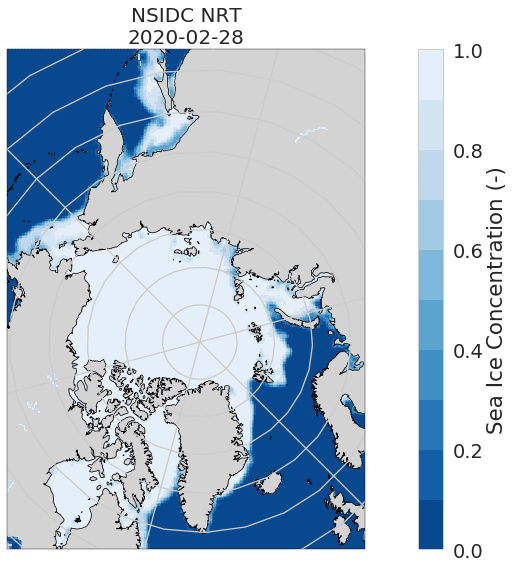

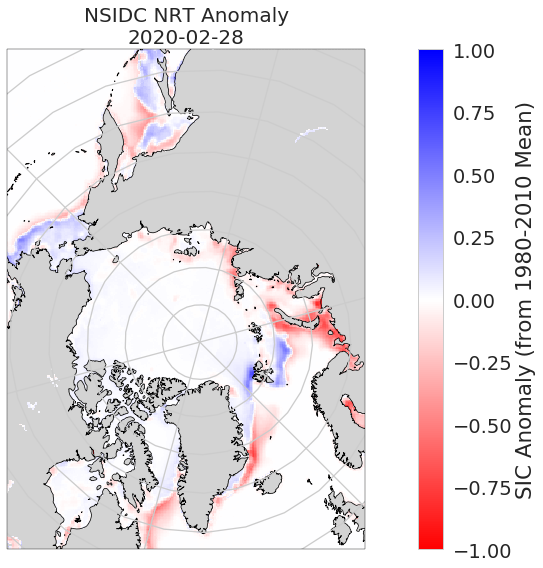

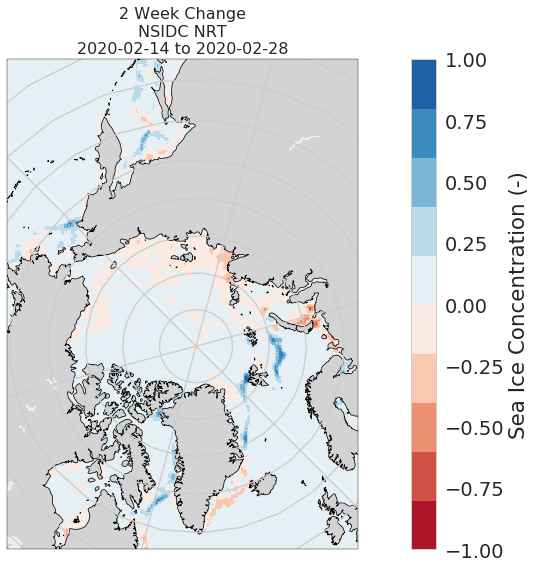

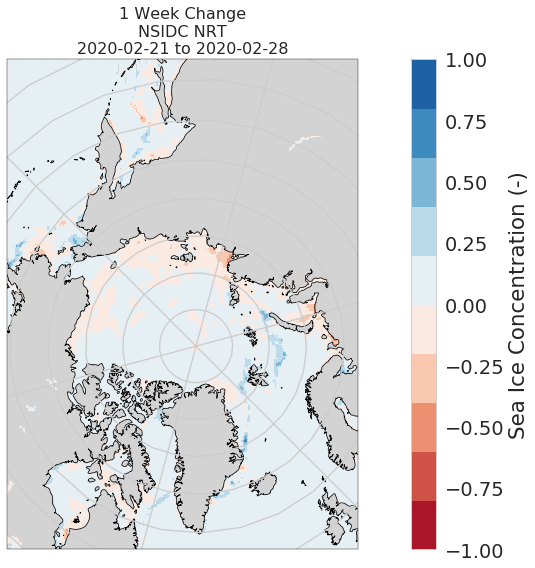

In [41]:
# Plot Obs and model SIC for date
(f, ax1) = ice_plot.polar_axis()
#f.set_size_inches(10, 5)
f.set_size_inches(15, 8)
# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
p={}
i=1
p[i]=obs1.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic, 
                      vmin=0, vmax=1,  cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('NSIDC NRT\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'), fontsize=20)

plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map.png'),bbox_inches='tight',dpi=200)

(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(15, 8)
#f.set_size_inches(10, 5)
# Obs NSIDC 0051
obs1 = da_81.sel(time=ctime, method='nearest')
cdoy = pd.to_datetime(ctime).timetuple().tm_yday
(obs1-mean_1980_2010_sic.isel(time=cdoy)).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_diff_2,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'SIC Anomaly (from 1980-2010 Mean)'})
ax1.set_title('NSIDC NRT Anomaly\n'+pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'), fontsize=20)
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_SIC_anomaly.png'),bbox_inches='tight',dpi=200)


# Plot obs change from yesterday
# Plot Obs and model SIC for date
(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(15, 8)
#f.set_size_inches(10, 5)
obs1 = da_81.sel(time=ctime, method='nearest')
ctime_m1 = obs1.time.values - np.timedelta64(14, 'D')
obs2 = da_81.sel(time=ctime_m1, method='nearest')
(obs1-obs2).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('2 Week Change\nNSIDC NRT\n'+pd.to_datetime(obs2.time.values).strftime('%Y-%m-%d')+' to '+ 
             pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'), fontsize=16)
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map_2Week_Change.png'),bbox_inches='tight',dpi=200)


# Plot obs change from last week
(f, ax1) = ice_plot.polar_axis()
f.set_size_inches(15, 8)
#f.set_size_inches(10, 5)
obs1 = da_81.sel(time=ctime, method='nearest')
ctime_m1 = obs1.time.values - np.timedelta64(7, 'D')
obs2 = da_81.sel(time=ctime_m1, method='nearest')
(obs1-obs2).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
ax1.set_title('1 Week Change\nNSIDC NRT\n'+pd.to_datetime(obs2.time.values).strftime('%Y-%m-%d')+' to '+ 
             pd.to_datetime(obs1.time.values).strftime('%Y-%m-%d'), fontsize=16)
plt.tight_layout()
f.savefig(os.path.join(fig_dir,'panArcticSIC_Forecast_Map_1Week_Change.png'),bbox_inches='tight',dpi=200)